In [1]:
import os
from datetime import datetime
import time
import pandas as pd
import pickle
import numpy as np

from scipy import stats
from tqdm import tqdm
from collections import defaultdict
from itertools import permutations

In [2]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

DATA_PATH = '/opt/ml/input/data/train_dataset/train_data.csv'
raw_train_df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
raw_train_df = raw_train_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

DATA_PATH = '/opt/ml/input/data/train_dataset/test_data.csv'
raw_test_df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
raw_test_df = raw_test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

full_df = pd.concat([raw_train_df, raw_test_df], ignore_index=True)
full_df = full_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [3]:
full_df_all_tags = sorted(list(set(full_df['KnowledgeTag'])))
print(len(full_df_all_tags))

912


### testId 마다 나오는 KnowledgeTag 확인

In [4]:
tag_groupby = full_df.groupby(['testId']).agg({
   'KnowledgeTag': 'unique',
})
tag_groupby.head()

,KnowledgeTag
testId,
A010000001,[5844]
A010000002,"[6803, 5844]"
A010000003,"[6806, 6804, 6307]"
A010000004,"[6806, 5845, 6804]"
A010000005,"[5846, 6308]"


In [5]:
tag_groupby['num_tags'] = tag_groupby['KnowledgeTag'].apply(len)
tag_groupby.head()

,KnowledgeTag,num_tags
testId,,
A010000001,[5844],1
A010000002,"[6803, 5844]",2
A010000003,"[6806, 6804, 6307]",3
A010000004,"[6806, 5845, 6804]",3
A010000005,"[5846, 6308]",2


In [6]:
def l2t(l):
    l.sort()
    return tuple(l)

In [7]:
tag_groupby['tag_tuple'] = tag_groupby['KnowledgeTag'].apply(l2t)  # hashable
# tag_groupby['tag_set'] = tag_groupby['KnowledgeTag'].apply(set)
tag_groupby.head()


,KnowledgeTag,num_tags,tag_tuple
testId,,,
A010000001,[5844],1,"(5844,)"
A010000002,"[5844, 6803]",2,"(5844, 6803)"
A010000003,"[6307, 6804, 6806]",3,"(6307, 6804, 6806)"
A010000004,"[5845, 6804, 6806]",3,"(5845, 6804, 6806)"
A010000005,"[5846, 6308]",2,"(5846, 6308)"


In [8]:
# tag tuple 이 겹치는 시험지들이 있을까?
print(len(tag_groupby['tag_tuple']))
print(len(set(tag_groupby['tag_tuple'])))

1537
751


<AxesSubplot:ylabel='Frequency'>

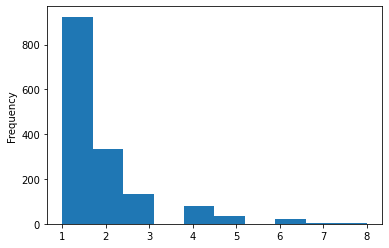

In [9]:
# 대부분 testId 당 tag 가 3개 이하이지만, 최대 8개의 tag 가 포함되기도 함
# 퀴즈 - 단원정리처럼 testId 마다 평가하는 주제 규모가 다른걸까..!
tag_groupby['num_tags'].plot.hist()

## 숫자 기반 Tag grouping
- 주관이 좀 들어감 ㅠㅠ

In [10]:
THRESH = 5

sep_by_value = []

prev_val = 0
tg = []
for tag in full_df_all_tags:
    if tag - prev_val > THRESH:
        if len(tg) > 0:
            sep_by_value.append(tg)
            tg = []
    tg.append(tag)
    prev_val = tag
if len(tg) > 0:
    sep_by_value.append(tg)
    tg = []
    
print(f"Total {len(sep_by_value)} tag groups.")
sorted_sep_by_value = sorted(sep_by_value, key=len, reverse=True)

# Largest group size
print(f"\nLargest group contains {len(sorted_sep_by_value[0])} tags.")
print(sorted_sep_by_value[0])

Total 191 tag groups.

Largest group contains 41 tags.
[2085, 2087, 2089, 2090, 2091, 2092, 2093, 2094, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2118, 2119, 2120, 2121, 2122, 2123, 2125, 2127, 2128, 2129, 2131, 2132, 2133]


In [11]:
# KnowledgeTag 별로 TagGroup 에 mapping

tag2group = {}
for tgidx, tg in enumerate(sep_by_value):
    for tag in tg:
        assert tag not in tag2group.keys()
        tag2group[tag] = tgidx

In [12]:
# 모든 태그가 빠짐없이 들어간거 확인
assert len(full_df_all_tags) == len(tag2group.keys())

## 데이터에 tag group 정보 추가하기
- 아래 cell 에서 사용하려는 train, test data 경로 설정
- `jupyter/pre-fe.ipynb` 로 미리 정답률 등 feature 가 계산된 파일이어야 합니다!!!!

In [91]:
data_dir = '/opt/ml/input/data/train_dataset/'
train_name = 'train_timedelta_basic_stats.csv'
test_name = 'test_timedelta_basic_stats.csv'

### Train, test data 를 읽어와서 KnowledgeTagGroup column 추가

In [92]:
train_df = pd.read_csv(os.path.join(data_dir, train_name), dtype=dtype, parse_dates=['Timestamp'])
train_df = train_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [93]:
train_df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testId_answer_rate,testId_answer_sum,assessmentItemID_answer_rate,assessmentItemID_answer_sum,knowledge_tag_mean,knowledge_tag_sum,assessment_category,assessment_category_mean,elapsed_time,et_by_kt,et_by_as
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3.0,0.947683,1268.0,0.982063,219.0,0.955022,637.0,6,0.709232,1.098612,2.183516,2.024569
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,8.0,0.947683,1268.0,0.964126,215.0,0.913187,3040.0,6,0.709232,2.079442,2.927493,2.828940
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,7.0,0.947683,1268.0,0.910314,203.0,0.913187,3040.0,6,0.709232,1.945910,2.927493,2.522950
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0,0.947683,1268.0,0.968610,216.0,0.913187,3040.0,6,0.709232,1.945910,2.927493,2.512345
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,11.0,0.947683,1268.0,0.941704,210.0,0.913187,3040.0,6,0.709232,2.397895,2.927493,3.168945


In [94]:
# KnowledgeTag 를 TagGroup 으로 mapping
def get_tag_group(t):
    return tag2group[t]

In [95]:
train_df['KnowledgeTagGroup'] = train_df['KnowledgeTag'].apply(get_tag_group)

In [96]:
test_df = pd.read_csv(os.path.join(data_dir, test_name), dtype=dtype, parse_dates=['Timestamp'])
test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [97]:
test_df['KnowledgeTagGroup'] = test_df['KnowledgeTag'].apply(get_tag_group)

### Tag group 기반 유사한 testId 모으기

In [20]:
def get_tag_sets(kts):
    # testId 내 등장하는 tag list -> set of tag groups 을 정렬된 tuple 로 반환
    tmp = set()
    for kt in kts:
        tmp.add(get_tag_group(kt))
    return tuple(sorted(tmp))

In [98]:
# Train data 내 testId 들의 tag group set 을 구함
testid_groupby = train_df.groupby(['testId'], as_index = False).agg({
    'KnowledgeTag': get_tag_sets
})
testid_groupby = testid_groupby.rename(columns={"KnowledgeTag": "KnowledgeTagGroups"})
testid_groupby.head(10)

,testId,KnowledgeTagGroups
0,A010000001,"(94,)"
1,A010000002,"(94, 101)"
2,A010000003,"(95, 101)"
3,A010000004,"(94, 101)"
4,A010000005,"(94, 95)"
5,A010000006,"(94, 95)"
6,A010000007,"(92,)"
7,A010000008,"(92,)"
8,A010000009,"(83,)"
9,A010000010,"(83,)"


In [99]:
# 동일한 tag group set 을 가진 testId 들을 list 화
testid_groups = testid_groupby.groupby(['KnowledgeTagGroups'])['testId'].apply(list)
testid_groups = testid_groups.to_frame()

testid_groups.head()

,testId
KnowledgeTagGroups,
"(0,)","[A080000081, A080000082, A080000083, A080000084]"
"(0, 53)","[A080000077, A080000078]"
"(0, 175)","[A080000079, A080000080]"
"(1, 69)",[A090000002]
"(1, 69, 70)",[A090000004]


In [100]:
id2tag = {}  # testId -> KnowledgeTagGroup
tag2ids = {} # KnowledgeTagGroup -> list of testIds

for tag, tests in testid_groups.iterrows():
    tag2ids[tag] = tests['testId']
    for test in tests['testId']:
        id2tag[test] = tag


In [101]:
# 각 유저에 대해 예측 대상인 마지막 testId 구함 -> 유사한 시험지들로만 데이터 구성해볼 예정
train_last_testids = train_df.groupby(['userID']).tail(1)['testId']
test_last_testids = test_df.groupby(['userID']).tail(1)['testId']
print(len(train_last_testids))
print(len(test_last_testids))

6698
744


In [102]:
# Train, test dataset 에 대해 unique last testIds 구함
last_testids = set(train_last_testids) | set(test_last_testids)
print(len(last_testids))

870


In [103]:
single_ktg = []  # 해당 KnowledgeTagGroup 을 가진 testId 가 한장뿐
single_ktg_lens = []

last_tags = []

for last in last_testids:
    last_tag = id2tag[last]
    same_ids = tag2ids[last_tag]
    last_tags.append(last_tag)
    if len(same_ids) == 1:
        single_ktg.append(last_tag)
        single_ktg_lens.append(len(last_tag))
print(len(single_ktg))

65


<AxesSubplot:ylabel='Count'>

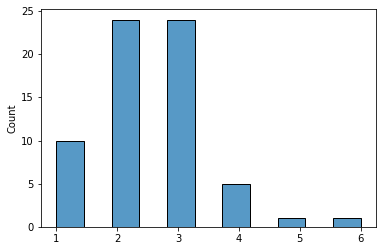

In [104]:
import seaborn as sns

# 해당 tag tuple 시험지가 한장만 존재하는 경우 -> tag tuple 의 subset 으로 확장?
# tag tuple 길이가 1인 경우 10 건은 확장하기 어려움 ㅠㅠ
sns.histplot(single_ktg_lens)

In [30]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> (1,2,3) (1,2) (1,3) (2,3) (1,) (2,) (3,)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)-1,0,-1))

def get_subsample_powerset(tag_tuple):
    pset = list(powerset(tag_tuple))
    
    tmp = []
    for s in pset:
        if s in tag2ids.keys():
            tmp.extend(tag2ids[s])
    if len(tmp) > 0:
        # print(f"{tag_tuple} filled by {pset}")
        return tmp

    print(f"No replacements available for {tag_tuple}! :(")
    return []

def get_subsample_minimal(tag_tuple):
    # Subset 크기 큰 순서대로 확장하고 대체가 되면 종료하는 버전
    for subsample_len in range(len(tag_tuple)-1, 0, -1):
        tmp = []
        pset = list(combinations(tag_tuple, subsample_len))

        for p in pset:
            if p in tag2ids.keys():
                tmp.extend(tag2ids[p])
        if len(tmp) > 0:
            # print(f"{tag_tuple} filled by {pset}")
            return tmp
    # print(f"No replacements available for {tag_tuple}! :(")
    return []

In [105]:
import copy

tag2ids_filled = copy.deepcopy(tag2ids)

In [66]:
for tag_tuple in single_ktg:  # testId 가 1장뿐인 tag tuple 만 powerset 의 testId 까지 사용
# for tag_tuple in last_tags:  # 모든 tag tuple 에 대해 
    # tag2ids_filled[tag_tuple].extend(get_subsample_powerset(tag_tuple))  # 모든 powerset 사용
    tag2ids_filled[tag_tuple].extend(get_subsample_minimal(tag_tuple))  # 크기 큰 subset 부터 사용하고 


No replacements available for (69, 70)! :(
No replacements available for (63, 86)! :(
No replacements available for (175,)! :(
No replacements available for (20,)! :(
No replacements available for (180,)! :(
No replacements available for (28, 29)! :(
No replacements available for (22,)! :(
No replacements available for (135,)! :(
No replacements available for (103,)! :(
No replacements available for (29, 67)! :(
No replacements available for (113,)! :(
No replacements available for (102,)! :(
No replacements available for (166,)! :(
No replacements available for (65,)! :(


In [108]:
# Verify single testids are filled
print(tag2ids[(141, 155)])
print(tag2ids_filled[(141, 155)])

['A070000112']
['A070000112']


In [106]:
train_last_testids_df = train_last_testids.to_frame()
train_last_testids_df.head()

,testId
744,A080000129
1677,A090000074
1953,A050000139
2786,A080000138
3707,A030000145


In [107]:
test_last_testids_df = test_last_testids.to_frame()
test_last_testids_df.head()

,testId
1035,A050000133
1706,A070000146
3023,A070000111
4283,A090000064
4670,A060000135


In [70]:
testid_groupby

,testId,KnowledgeTagGroups
0,A010000001,"(94,)"
1,A010000002,"(94, 101)"
2,A010000003,"(95, 101)"
3,A010000004,"(94, 101)"
4,A010000005,"(94, 95)"
...,...,...
1532,A090000070,"(48, 165)"
1533,A090000071,"(48, 165)"
1534,A090000072,"(48, 65)"
1535,A090000073,"(48, 65, 169)"


In [109]:
# 마지막 testId 의 KnowledgeTagGroup 구함
train_last_testids_df['KnowledgeTagGroups'] = train_last_testids_df['testId'].apply(lambda x: testid_groupby.loc[testid_groupby['testId'] == x]['KnowledgeTagGroups'].values[0])
train_last_testids_df.head()

,testId,KnowledgeTagGroups
744,A080000129,"(49,)"
1677,A090000074,"(48, 65, 169)"
1953,A050000139,"(12,)"
2786,A080000138,"(138,)"
3707,A030000145,"(124,)"


In [110]:
# 마지막 testId 의 KnowledgeTagGroup 구함
test_last_testids_df['KnowledgeTagGroups'] = test_last_testids_df['testId'].apply(lambda x: testid_groupby.loc[testid_groupby['testId'] == x]['KnowledgeTagGroups'].values[0])
test_last_testids_df.head()

,testId,KnowledgeTagGroups
1035,A050000133,"(79,)"
1706,A070000146,"(145,)"
3023,A070000111,"(141, 155, 186)"
4283,A090000064,"(47,)"
4670,A060000135,"(30,)"


In [111]:
train_last_testids_df['similar_testId'] = train_last_testids_df['KnowledgeTagGroups'].apply(lambda x: tag2ids_filled[x])
train_last_testids_df = train_last_testids_df.drop(columns=['KnowledgeTagGroups'])
train_last_testids_df.head()


,testId,similar_testId
744,A080000129,"[A080000115, A080000116, A080000123, A08000012..."
1677,A090000074,"[A090000073, A090000074]"
1953,A050000139,"[A030000062, A030000063, A030000064, A03000006..."
2786,A080000138,"[A080000131, A080000132, A080000133, A08000013..."
3707,A030000145,"[A010000113, A010000114, A010000115, A01000012..."


In [112]:
test_last_testids_df['similar_testId'] = test_last_testids_df['KnowledgeTagGroups'].apply(lambda x: tag2ids_filled[x])
test_last_testids_df = test_last_testids_df.drop(columns=['KnowledgeTagGroups'])
test_last_testids_df.head()


,testId,similar_testId
1035,A050000133,"[A050000108, A050000109, A050000110, A05000011..."
1706,A070000146,"[A070000128, A070000130, A070000132, A07000013..."
3023,A070000111,"[A070000111, A070000120, A070000121]"
4283,A090000064,"[A050000001, A050000002, A050000003, A05000000..."
4670,A060000135,"[A060000135, A060000136, A060000142]"


In [113]:
import numpy as np

train_df['similar_testId'] = np.nan
train_df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testId_answer_rate,testId_answer_sum,assessmentItemID_answer_rate,assessmentItemID_answer_sum,knowledge_tag_mean,knowledge_tag_sum,assessment_category,assessment_category_mean,elapsed_time,et_by_kt,et_by_as,KnowledgeTagGroup,similar_testId
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3.0,0.947683,1268.0,0.982063,219.0,0.955022,637.0,6,0.709232,1.098612,2.183516,2.024569,107,NaN
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,8.0,0.947683,1268.0,0.964126,215.0,0.913187,3040.0,6,0.709232,2.079442,2.927493,2.828940,107,NaN
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,7.0,0.947683,1268.0,0.910314,203.0,0.913187,3040.0,6,0.709232,1.945910,2.927493,2.522950,107,NaN
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0,0.947683,1268.0,0.968610,216.0,0.913187,3040.0,6,0.709232,1.945910,2.927493,2.512345,107,NaN
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,11.0,0.947683,1268.0,0.941704,210.0,0.913187,3040.0,6,0.709232,2.397895,2.927493,3.168945,107,NaN


In [114]:
test_df['similar_testId'] = np.nan
test_df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testId_answer_rate,testId_answer_sum,assessmentItemID_answer_rate,assessmentItemID_answer_sum,knowledge_tag_mean,knowledge_tag_sum,assessment_category,assessment_category_mean,elapsed_time,et_by_kt,et_by_as,KnowledgeTagGroup,similar_testId
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,26.0,0.560944,856.0,0.646789,141.0,0.641379,1023.0,5,0.658208,3.258097,3.384855,3.540414,47,NaN
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,94.0,0.560944,856.0,0.628440,137.0,0.641379,1023.0,5,0.658208,4.543295,3.384855,3.664071,47,NaN
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,5.0,0.560944,856.0,0.577982,126.0,0.670013,1535.0,5,0.658208,1.609438,3.500664,3.138796,47,NaN
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,7.0,0.560944,856.0,0.655963,143.0,0.670013,1535.0,5,0.658208,1.945910,3.500664,3.702171,47,NaN
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,3.0,0.560944,856.0,0.307339,67.0,0.568970,2314.0,5,0.658208,1.098612,3.626136,3.119886,47,NaN


In [115]:
train_df.update(train_last_testids_df)
# NaN 은 아래에서 back fill 로 채울 예정
train_df[740:746]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testId_answer_rate,testId_answer_sum,assessmentItemID_answer_rate,assessmentItemID_answer_sum,knowledge_tag_mean,knowledge_tag_sum,assessment_category,assessment_category_mean,elapsed_time,et_by_kt,et_by_as,KnowledgeTagGroup,similar_testId
740,0,A080129002,A080000129,1,2020-12-23 03:35:54,2723,86.000000,0.360111,780.0,0.360111,130.0,0.476454,344.0,8,0.502598,4.454347,2.975214,2.857286,49,NaN
741,0,A080129003,A080000129,0,2020-12-23 03:37:20,2725,83.000000,0.360111,780.0,0.204986,74.0,0.301939,436.0,8,0.502598,4.418841,2.734488,2.473111,49,NaN
742,0,A080129004,A080000129,1,2020-12-23 03:38:43,2725,91.000000,0.360111,780.0,0.448753,162.0,0.301939,436.0,8,0.502598,4.510860,2.734488,2.499002,49,NaN
743,0,A080129005,A080000129,0,2020-12-23 03:40:14,2725,5.000000,0.360111,780.0,0.398892,144.0,0.301939,436.0,8,0.502598,1.609438,2.734488,2.583565,49,NaN
744,0,A080129006,A080000129,0,2020-12-23 03:40:19,2725,65.778707,0.360111,780.0,0.155125,56.0,0.301939,436.0,8,0.502598,4.186296,2.734488,3.382273,49,"[A080000115, A080000116, A080000123, A08000012..."
745,1,A040013001,A040000013,1,2020-01-06 08:40:43,2048,183.000000,0.595472,789.0,0.800000,212.0,0.616900,971.0,4,0.684056,5.209486,3.699489,3.564511,44,NaN


In [116]:
test_df.update(test_last_testids_df)
test_df[1032:1038]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testId_answer_rate,testId_answer_sum,assessmentItemID_answer_rate,assessmentItemID_answer_sum,knowledge_tag_mean,knowledge_tag_sum,assessment_category,assessment_category_mean,elapsed_time,et_by_kt,et_by_as,KnowledgeTagGroup,similar_testId
1032,3,A050133005,A050000133,1,2020-10-26 13:12:36,5288,16.000000,0.653970,1219.0,0.802575,187.0,0.627408,1433.0,5,0.658208,2.772589,3.835096,3.001590,79,NaN
1033,3,A050133006,A050000133,1,2020-10-26 13:12:52,5288,19.000000,0.653970,1219.0,0.652361,152.0,0.627408,1433.0,5,0.658208,2.944439,3.835096,3.384596,79,NaN
1034,3,A050133007,A050000133,0,2020-10-26 13:13:11,5289,46.000000,0.653970,1219.0,0.437768,102.0,0.560703,1658.0,5,0.658208,3.828641,3.729360,3.794574,79,NaN
1035,3,A050133008,A050000133,-1,2020-10-26 13:13:57,5289,89.076807,0.653970,1219.0,0.532189,124.0,0.560703,1658.0,5,0.658208,4.489499,3.729360,4.012263,79,"[A050000108, A050000109, A050000110, A05000011..."
1036,4,A040001001,A040000001,1,2020-02-11 04:13:36,7271,8.000000,0.893585,1184.0,0.969811,257.0,0.876386,3715.0,4,0.684056,2.079442,3.046992,2.260932,110,NaN
1037,4,A040001002,A040000001,1,2020-02-11 04:13:44,7271,17.000000,0.893585,1184.0,0.909434,241.0,0.876386,3715.0,4,0.684056,2.833213,3.046992,2.933387,110,NaN


In [117]:
train_df = train_df.fillna(method='bfill')
train_df[740:746]


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testId_answer_rate,testId_answer_sum,assessmentItemID_answer_rate,assessmentItemID_answer_sum,knowledge_tag_mean,knowledge_tag_sum,assessment_category,assessment_category_mean,elapsed_time,et_by_kt,et_by_as,KnowledgeTagGroup,similar_testId
740,0,A080129002,A080000129,1,2020-12-23 03:35:54,2723,86.000000,0.360111,780.0,0.360111,130.0,0.476454,344.0,8,0.502598,4.454347,2.975214,2.857286,49,"[A080000115, A080000116, A080000123, A08000012..."
741,0,A080129003,A080000129,0,2020-12-23 03:37:20,2725,83.000000,0.360111,780.0,0.204986,74.0,0.301939,436.0,8,0.502598,4.418841,2.734488,2.473111,49,"[A080000115, A080000116, A080000123, A08000012..."
742,0,A080129004,A080000129,1,2020-12-23 03:38:43,2725,91.000000,0.360111,780.0,0.448753,162.0,0.301939,436.0,8,0.502598,4.510860,2.734488,2.499002,49,"[A080000115, A080000116, A080000123, A08000012..."
743,0,A080129005,A080000129,0,2020-12-23 03:40:14,2725,5.000000,0.360111,780.0,0.398892,144.0,0.301939,436.0,8,0.502598,1.609438,2.734488,2.583565,49,"[A080000115, A080000116, A080000123, A08000012..."
744,0,A080129006,A080000129,0,2020-12-23 03:40:19,2725,65.778707,0.360111,780.0,0.155125,56.0,0.301939,436.0,8,0.502598,4.186296,2.734488,3.382273,49,"[A080000115, A080000116, A080000123, A08000012..."
745,1,A040013001,A040000013,1,2020-01-06 08:40:43,2048,183.000000,0.595472,789.0,0.800000,212.0,0.616900,971.0,4,0.684056,5.209486,3.699489,3.564511,44,"[A090000073, A090000074]"


In [118]:
test_df = test_df.fillna(method='bfill')
test_df[1032:1038]


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testId_answer_rate,testId_answer_sum,assessmentItemID_answer_rate,assessmentItemID_answer_sum,knowledge_tag_mean,knowledge_tag_sum,assessment_category,assessment_category_mean,elapsed_time,et_by_kt,et_by_as,KnowledgeTagGroup,similar_testId
1032,3,A050133005,A050000133,1,2020-10-26 13:12:36,5288,16.000000,0.653970,1219.0,0.802575,187.0,0.627408,1433.0,5,0.658208,2.772589,3.835096,3.001590,79,"[A050000108, A050000109, A050000110, A05000011..."
1033,3,A050133006,A050000133,1,2020-10-26 13:12:52,5288,19.000000,0.653970,1219.0,0.652361,152.0,0.627408,1433.0,5,0.658208,2.944439,3.835096,3.384596,79,"[A050000108, A050000109, A050000110, A05000011..."
1034,3,A050133007,A050000133,0,2020-10-26 13:13:11,5289,46.000000,0.653970,1219.0,0.437768,102.0,0.560703,1658.0,5,0.658208,3.828641,3.729360,3.794574,79,"[A050000108, A050000109, A050000110, A05000011..."
1035,3,A050133008,A050000133,-1,2020-10-26 13:13:57,5289,89.076807,0.653970,1219.0,0.532189,124.0,0.560703,1658.0,5,0.658208,4.489499,3.729360,4.012263,79,"[A050000108, A050000109, A050000110, A05000011..."
1036,4,A040001001,A040000001,1,2020-02-11 04:13:36,7271,8.000000,0.893585,1184.0,0.969811,257.0,0.876386,3715.0,4,0.684056,2.079442,3.046992,2.260932,110,"[A070000128, A070000130, A070000132, A07000013..."
1037,4,A040001002,A040000001,1,2020-02-11 04:13:44,7271,17.000000,0.893585,1184.0,0.909434,241.0,0.876386,3715.0,4,0.684056,2.833213,3.046992,2.933387,110,"[A070000128, A070000130, A070000132, A07000013..."


### Similar testId 만 filtering

In [47]:
change_to_set = lambda x: set(x) if type(x) == list else set([x])

In [119]:
tid_set = train_df.testId.map(change_to_set).values
similar_tid_set = train_df.similar_testId.map(change_to_set).values
filtered_train_df = train_df[(tid_set & similar_tid_set).astype(bool)]
print(len(filtered_train_df))

159752


In [120]:
tid_set = test_df.testId.map(change_to_set).values
similar_tid_set = test_df.similar_testId.map(change_to_set).values
filtered_test_df = test_df[(tid_set & similar_tid_set).astype(bool)]
print(len(filtered_test_df))

17962


### Filtered dataset 의 규모, 유저별 문제수 min/max 등 확인

In [121]:
train_filtered_user_gb = filtered_train_df.groupby('userID').agg({
    'assessmentItemID': 'count'
})
train_filtered_user_gb.head()

,assessmentItemID
userID,
0,6
1,12
2,14
5,50
6,10


In [129]:
train_filtered_user_gb['assessmentItemID'].quantile([0.25,0.5,0.75])

0.25     7.0
0.50    12.0
0.75    27.0
Name: assessmentItemID, dtype: float64

<AxesSubplot:ylabel='Frequency'>

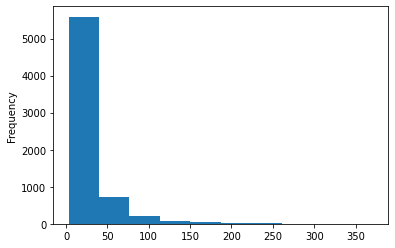

In [127]:
train_filtered_user_gb['assessmentItemID'].plot.hist()

In [122]:
test_filtered_user_gb = filtered_test_df.groupby('userID').agg({
    'assessmentItemID': 'count'
})
test_filtered_user_gb.head()

,assessmentItemID
userID,
3,106
4,40
13,8
17,64
26,7


In [130]:
test_filtered_user_gb['assessmentItemID'].quantile([0.25,0.5,0.75])

0.25     7.00
0.50    10.50
0.75    26.25
Name: assessmentItemID, dtype: float64

<AxesSubplot:ylabel='Frequency'>

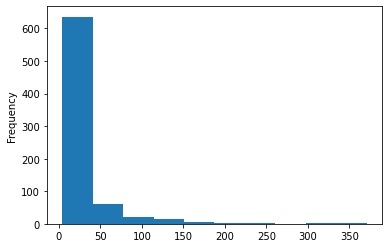

In [128]:
test_filtered_user_gb['assessmentItemID'].plot.hist()

In [123]:
for gb in [train_filtered_user_gb, test_filtered_user_gb]:
    print('*'*20, " Stats: Number of assessmentItemID ", '*'*20)
    print(f"max {max(gb['assessmentItemID'])}, min {min(gb['assessmentItemID'])}, mean {np.mean(gb['assessmentItemID'])}, median {np.median(gb['assessmentItemID'])}")
    print()

********************  Stats: Number of assessmentItemID  ********************
max 371, min 3, mean 23.8507017020006, median 12.0

********************  Stats: Number of assessmentItemID  ********************
max 371, min 4, mean 24.142473118279568, median 10.5



In [124]:
filtered_train_df = filtered_train_df.drop(columns=['similar_testId'])
filtered_train_df = filtered_train_df.reset_index(drop=True)
filtered_train_df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testId_answer_rate,testId_answer_sum,assessmentItemID_answer_rate,assessmentItemID_answer_sum,knowledge_tag_mean,knowledge_tag_sum,assessment_category,assessment_category_mean,elapsed_time,et_by_kt,et_by_as,KnowledgeTagGroup
0,0,A080129001,A080000129,1,2020-12-23 03:35:32,2723,22.0,0.360111,780.0,0.592798,214.0,0.476454,344.0,8,0.502598,3.091042,2.975214,3.093141,49
1,0,A080129002,A080000129,1,2020-12-23 03:35:54,2723,86.0,0.360111,780.0,0.360111,130.0,0.476454,344.0,8,0.502598,4.454347,2.975214,2.857286,49
2,0,A080129003,A080000129,0,2020-12-23 03:37:20,2725,83.0,0.360111,780.0,0.204986,74.0,0.301939,436.0,8,0.502598,4.418841,2.734488,2.473111,49
3,0,A080129004,A080000129,1,2020-12-23 03:38:43,2725,91.0,0.360111,780.0,0.448753,162.0,0.301939,436.0,8,0.502598,4.510860,2.734488,2.499002,49
4,0,A080129005,A080000129,0,2020-12-23 03:40:14,2725,5.0,0.360111,780.0,0.398892,144.0,0.301939,436.0,8,0.502598,1.609438,2.734488,2.583565,49


In [125]:
filtered_test_df = filtered_test_df.drop(columns=['similar_testId'])
filtered_test_df = filtered_test_df.reset_index(drop=True)
filtered_test_df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,testId_answer_rate,testId_answer_sum,assessmentItemID_answer_rate,assessmentItemID_answer_sum,knowledge_tag_mean,knowledge_tag_sum,assessment_category,assessment_category_mean,elapsed_time,et_by_kt,et_by_as,KnowledgeTagGroup
0,3,A050108001,A050000108,1,2020-08-09 14:15:42,5283,41.0,0.804718,1228.0,0.857798,187.0,0.762096,3229.0,5,0.658208,3.713572,3.54022,3.419548,79
1,3,A050108002,A050000108,1,2020-08-09 14:16:23,5283,11.0,0.804718,1228.0,0.834862,182.0,0.762096,3229.0,5,0.658208,2.397895,3.54022,2.819150,79
2,3,A050108003,A050000108,1,2020-08-09 14:16:34,5283,48.0,0.804718,1228.0,0.807339,176.0,0.762096,3229.0,5,0.658208,3.871201,3.54022,3.516157,79
3,3,A050108004,A050000108,1,2020-08-09 14:17:22,5283,53.0,0.804718,1228.0,0.866972,189.0,0.762096,3229.0,5,0.658208,3.970292,3.54022,2.795905,79
4,3,A050108005,A050000108,1,2020-08-09 14:18:15,5283,27.0,0.804718,1228.0,0.821101,179.0,0.762096,3229.0,5,0.658208,3.295837,3.54022,3.227989,79


### Filtered dataset 저장

In [ ]:
filtered_train_df.to_csv(os.path.join(data_dir, f"{train_name.split('.')[0]}_filtered.csv"), sep=',', index=False)
filtered_test_df.to_csv(os.path.join(data_dir, f"{test_name.split('.')[0]}_filtered.csv"), sep=',', index=False)